In [1]:
import methods.torch_nvd as nvd
import methods.utils as utils

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import pandas as pd
import numpy as np

import pandas as pd
import networkx as nx

import scipy.stats as st

from math import comb
import seaborn as sns

# Common test variables
Run python script with variables common to all synthetic experiments, also sets random seed.

In [2]:
%run -i "test_variables.py"

# Defining variables in the notebook for code highlighting purposes
metrics = metrics
local_tests = local_tests
local_num_nodes_range = local_num_nodes_range
random_run_metrics = random_run_metrics
mds_runs = mds_runs
SBM_runs = SBM_runs
node_size = node_size
edge_color = edge_color
local_edge_width = local_edge_width
local_edge_alpha = local_edge_alpha
global_edge_width = global_edge_width
global_edge_alpha = global_edge_alpha
labelpad=labelpad
fontsize=fontsize

# Group Consensus

In [3]:
experiment_folder = 'group_consensus/'

### Local Setup

In [4]:
def draw_limited_normal_stances(mu, sd, n):
    """
    Draw n stances from a normal distribution with mean mu and standard deviation sd.
    Stances are limited to the interval [0, 1].
    """
    
    # draw draw_factor times more stances from a normal distribution than needed
    draw_factor = 2
    stances = np.random.normal(loc=mu, scale=sd, size=n*draw_factor)

    # keep only stances in [0, 1]
    discard_map = (stances < 0) | (stances > 1)
    stances = stances[~discard_map]

    if len(stances) > n:
        stances = stances[:n]
    else:
        raise ValueError(f'Not enough stances ({len(stances)}) were drawn')

    assert len(stances) == n

    return stances

[0.01       0.07333333 0.13666667 0.2       ]
Figure saved


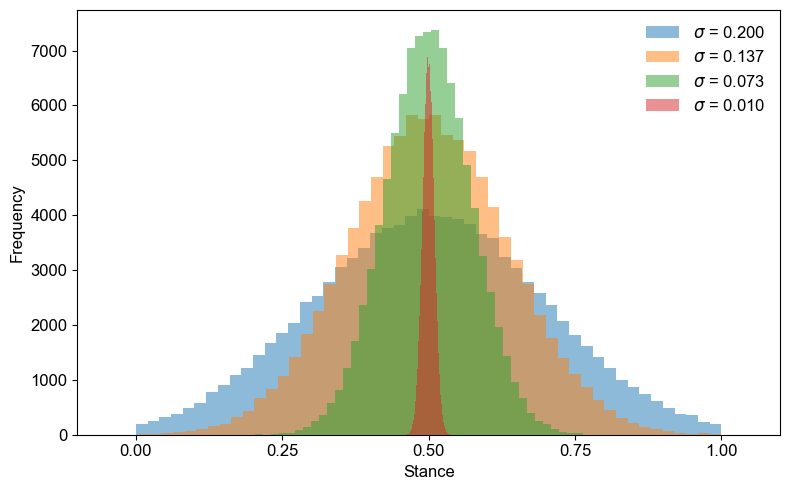

In [5]:
# x_range contains sd values for opinions, from 0.5 to 0 in 0.1 increments
max_x = 0.2
min_x = 0.01
number_of_steps = 4

x_range = np.linspace(min_x, max_x, number_of_steps)
print(x_range)

cmap = utils.cmap("qualitative", n=len(x_range), as_colormap=False, shuffle=False)

# visualizing normal distributions with different standard deviations
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

num_stances = 100000

for i, sd in enumerate(x_range[::-1]):

    stances = draw_limited_normal_stances(0.5, sd, num_stances)
    plt.hist(stances, bins=50, alpha=0.5, color=cmap[i], label='$\sigma$'+f' = {sd:.3f}', zorder=10, density=False);

    # x = np.linspace(0, 1, 100)
    # plt.plot(x, st.norm.pdf(x, 0.5, sd))

# Set x limits to 0 and 1
ax.set_xlim(-0.1, 1.1)

# Set x ticks to 0, 0.25, 0.5, 0.75, 1
plt.xticks(np.arange(0, 1.1, 0.25), fontsize=fontsize)
plt.yticks(fontsize=fontsize)

plt.ylabel('Frequency', fontsize=fontsize)
plt.xlabel('Stance', fontsize=fontsize)

plt.legend(frameon=False, fontsize=fontsize, loc='upper right')

fig.tight_layout()

utils.save_figure('normal_distributions', experiment_folder, overwrite=True)

In [6]:
comms = 3
nodes_per_comm=2

sd = 0.1 

# Generate stances
stances = draw_limited_normal_stances(0.5, sd, nodes_per_comm*comms)

# Generate the opinion matrix
o = np.zeros((comms*nodes_per_comm, comms))
for i in range(comms):
    o[i*nodes_per_comm:(i+1)*nodes_per_comm, i] = stances[i*nodes_per_comm:(i+1)*nodes_per_comm]
o = pd.DataFrame(o)
o

,0,1,2
0,0.519834,0.000000,0.000000
1,0.604832,0.000000,0.000000
2,0.000000,0.533749,0.000000
3,0.000000,0.478776,0.000000
4,0.000000,0.000000,0.633389
5,0.000000,0.000000,0.509995


### Local Results

[0.2     0.17625 0.1525  0.12875 0.105   0.08125 0.0575  0.03375 0.01   ]


d:\OneDrive\ITU\Bachelor's Project\Quantifying-Multipolar-Polarization\methods\torch_nvd.py:88: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3641.)
  diff_T = diff.T


Figure saved


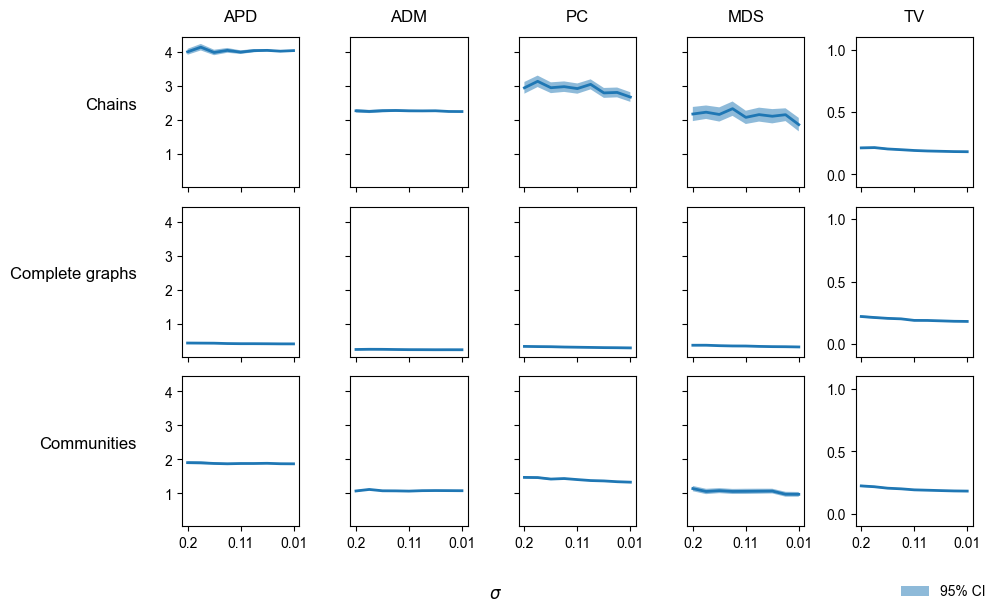

In [7]:
comms = 3  # Number of communities in the local community network
num_nodes = 12

min_x = 0.01
max_x = 0.2
number_of_steps = 9
x_range = np.linspace(max_x, min_x, number_of_steps)
print(x_range)

fig, ax = plt.subplots(len(local_tests), len(metrics), figsize=(len(metrics)*2, len(local_tests)*2), sharex=True)

# Set limits and ticks
for i in range(len(local_tests)):
    for j in range(len(metrics)):
        # TV y-ticks and limits
        if j == len(metrics)-1:
            ax[i, j].set_yticks([0, 0.5, 1])
            ax[i, j].set_ylim([-0.1, 1.1])
        # All other subplots
        else:
            ax[i, j].set_xlim(x_range[0]+x_range[-1], x_range[-1]-x_range[-1])
            ax[i, j].set_xticks(x_range[::4])
            ax[i, j].set_xticklabels([str(round(sd, 2)) for sd in x_range[::4]])

# Sharing x- and y-axes for all subplots except the last column
utils.share_axes(ax[:,:-1], sharex=True, sharey=True)

for test_index, (graph_name, graph_type) in enumerate(local_tests):

    for metric_index, (metric_name, polarization_metric) in enumerate(metrics):

        # Initialize arrays to store the means and confidence intervals of repeated runs
        means = np.zeros(len(x_range))
        lower_confs = np.zeros(len(x_range))
        higher_confs = np.zeros(len(x_range))

        for x_index, sd in enumerate(x_range):

            nodes_per_comm = num_nodes // comms

            run_pols = np.zeros(mds_runs)

            for run in range(mds_runs):
            
                if graph_type == utils.make_community_graph:
                    G = graph_type(n_comms=comms, nodes_per_comm=nodes_per_comm)
                else:
                    G = graph_type(num_nodes)

                # Generate stances
                stances = draw_limited_normal_stances(0.5, sd, nodes_per_comm*comms)

                # Generate the opinion matrix
                o = np.zeros((comms*nodes_per_comm, comms))
                for i in range(comms):
                    o[i*nodes_per_comm:(i+1)*nodes_per_comm, i] = stances[i*nodes_per_comm:(i+1)*nodes_per_comm]
                o = pd.DataFrame(o)

                tensor = nvd.make_tensor(G, o)
                polarization = polarization_metric(tensor)

                run_pols[run] = polarization

                # # Only keep the first run
                # if polarization_metric not in random_run_metrics:
                #     run_pols = np.array([run_pols[0]])
                #     break
        
            # Add small random noise to avoid RuntimeWarning: invalid value encountered in multiply
            run_pols += np.random.normal(0, 1e-10, run_pols.size)

            # Calculate the 95% confidence intervals
            lower_conf, higher_conf = st.t.interval(0.95, run_pols.size-1, loc=np.mean(run_pols), scale=st.sem(run_pols)) # means[x_index]

            lower_confs[x_index] = lower_conf
            higher_confs[x_index] = higher_conf

            means[x_index] = np.mean(run_pols)

        ax[test_index, metric_index].fill_between(x_range, higher_confs, lower_confs, alpha=.5, linewidth=0, label='95% CI')

        # Draw line at 0 for layout purposes
        # ax[test_index, metric_index].hlines(0, x_range[0]-x_range[0], xmax=x_range[-1]+x_range[0], colors='dimgrey', linestyles='dashed', label='Expected')

        ax[test_index, metric_index].plot(x_range, means, lw=2)

        # Add title to the first row
        if test_index == 0:
            ax[test_index, metric_index].set_title(metric_name, fontsize=12, y=1.05, ha='center')

        # Add title to the first column
        if metric_index == 0:
            ax[test_index, metric_index].set_ylabel(graph_name, rotation=0, labelpad=20, fontsize=12, ha='right')

# fig.supylabel('Polarization', x=0.08)
fig.supxlabel('$\sigma$', fontsize=12, y=-0.01)

# Getting legend from last MDS plot
handles, labels = ax[len(local_tests)-1, len(metrics)-2].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', fontsize=fontsize-2, frameon=False, ncols=len(labels))

fig.tight_layout()

utils.save_figure("local_res", experiment_folder, overwrite=True)

### Global Setup

In [8]:
# Experiment variables

p_in = 0.1
p_out = 0.01
n_comms = 3
intercon = n_comms-1
nodes_per_comm = 100

min_x = 0.01
max_x = 0.2
number_of_steps = 9

x_range = np.linspace(max_x, min_x, number_of_steps)
print(x_range)

[0.2     0.17625 0.1525  0.12875 0.105   0.08125 0.0575  0.03375 0.01   ]


### Global Results

Text(0.5, 1.0, 'TV, sd=0.01, emp_sd_stances:9.839280647095537e-06, emp_sd_o:0.2342268261730541')

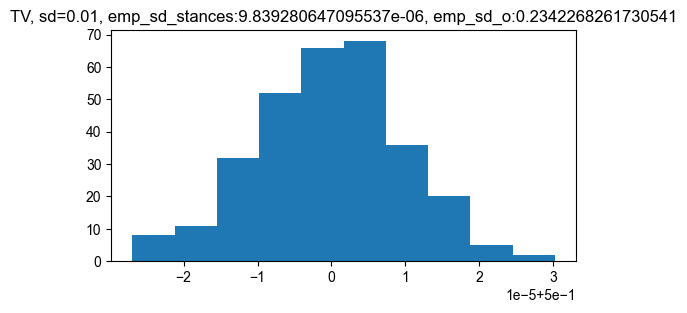

In [9]:
stances = draw_limited_normal_stances(0.5, 0.00001, 300)

figure, axes = plt.subplots(1, 1, figsize=(6, 3))
axes.hist(stances)
axes.set_title(f"{metric_name}, sd={sd}, emp_sd_stances:{np.std(stances)}, emp_sd_o:{np.std(o.iloc[:, 0])}")

Figure saved


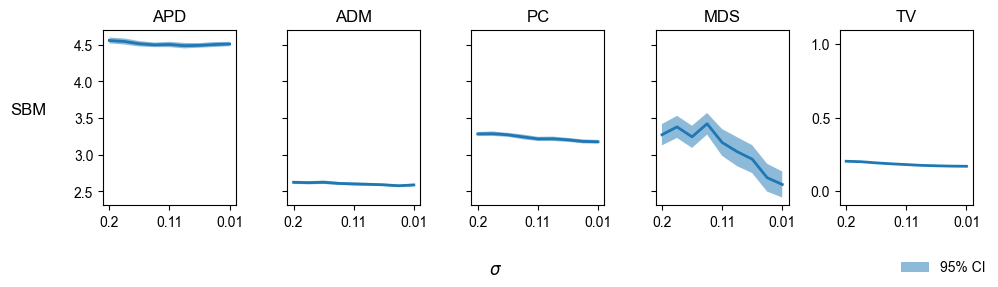

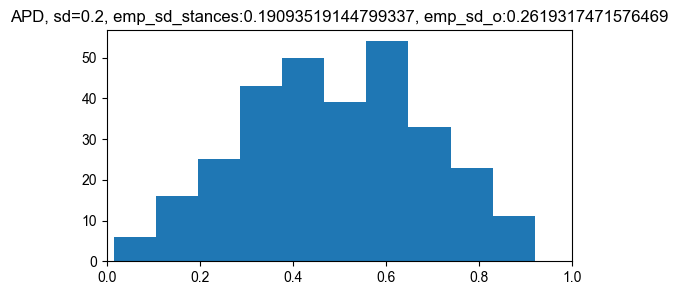

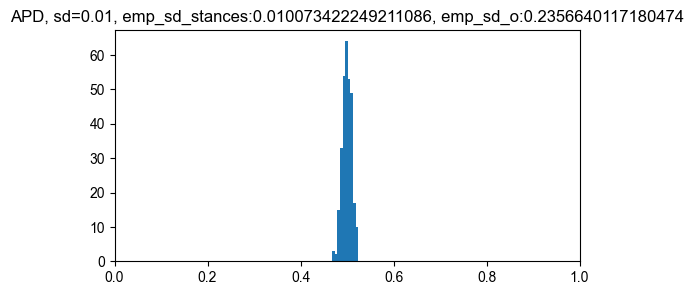

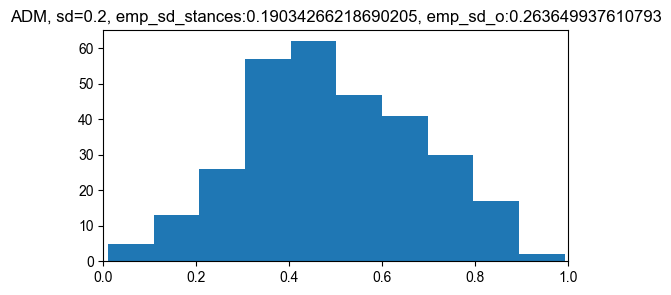

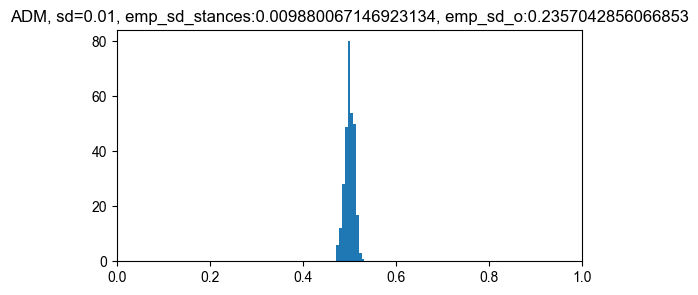

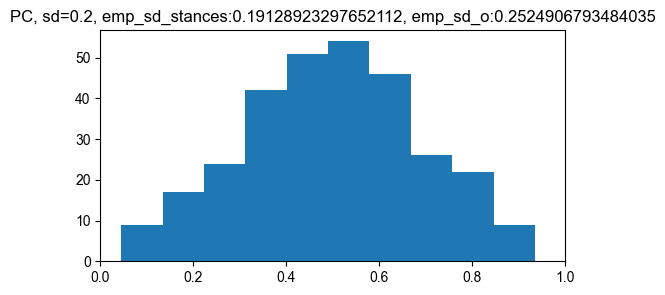

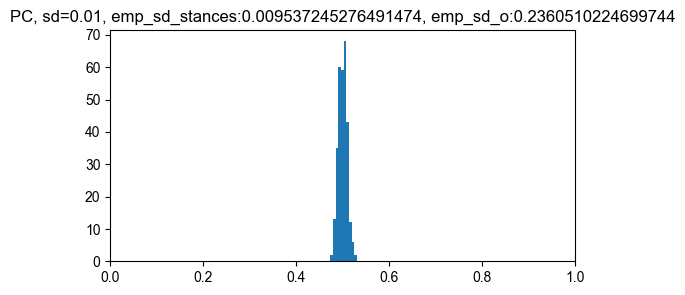

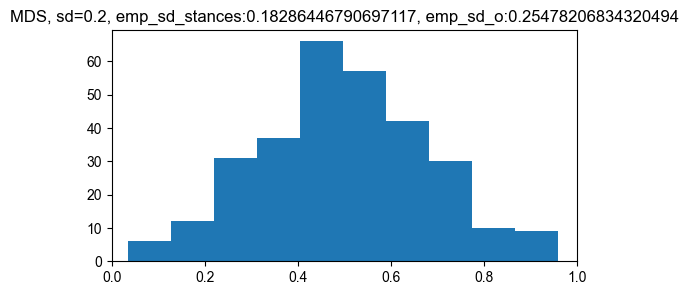

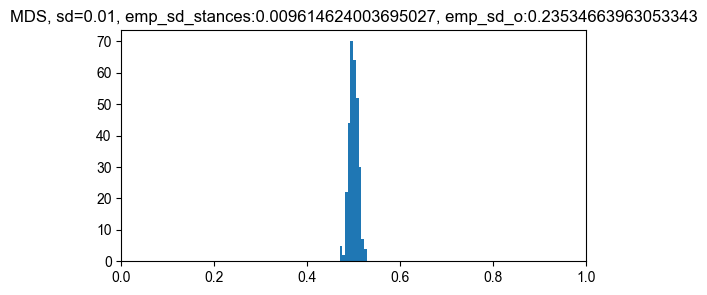

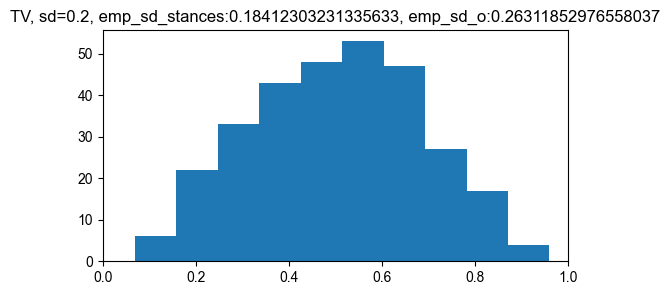

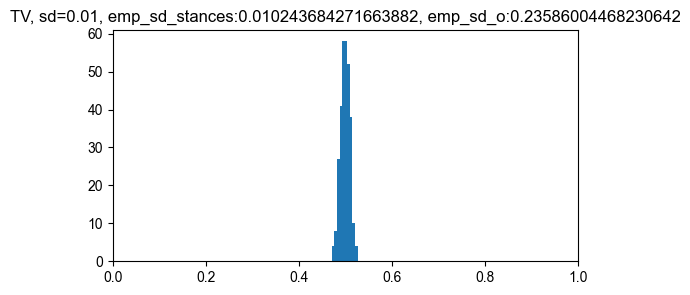

In [10]:
# Usint custom run numbers for this experiment
mds_runs = 100
SBM_runs = 100

fig, ax = plt.subplots(1, len(metrics), figsize=(len(metrics)*2, 2.8), sharex=True)

# Set limits and ticks
for j in range(len(metrics)):
    # TV y-ticks and limits
    if j == len(metrics)-1:
        ax[j].set_yticks([0, 0.5, 1])
        ax[j].set_ylim([-0.1, 1.1])

    ax[j].set_xlim(x_range[0]+x_range[-1], x_range[-1]-x_range[-1])
    ax[j].set_xticks(x_range[::4])      
    ax[j].set_xticklabels([str(round(sd, 2)) for sd in x_range[::4]])
        
# Sharing x- and y-axes for all subplots except the last column
utils.share_axes(ax[:-1], sharex=True, sharey=True)


for metric_index, (metric_name, polarization_metric) in enumerate(metrics):

    if polarization_metric == nvd.MDS_manifold:
        num_runs = mds_runs
    else:
        num_runs = SBM_runs

    # initialize array for polarization values with shape (num_runs,len(x_range))
    run_pols = np.zeros((num_runs, len(x_range)))

    for x_index, sd in enumerate(x_range):

        for run in range(num_runs):
            
            G = utils.stochastic_block_model(n_comms, nodes_per_comm, p_in, p_out, community_labels=False, positions=False)

            # Generate stances
            stances = draw_limited_normal_stances(0.5, sd, nodes_per_comm*comms)

            # Generate the opinion matrix
            o = np.zeros((comms*nodes_per_comm, comms))
            for i in range(comms):
                o[i*nodes_per_comm:(i+1)*nodes_per_comm, i] = stances[i*nodes_per_comm:(i+1)*nodes_per_comm]
            o = pd.DataFrame(o)

            # Debugging
            if (x_index == 0 or x_index == len(x_range) - 1) and run == 0:
                figure, axes = plt.subplots(1, 1, figsize=(6, 3))
                axes.hist(stances)
                axes.set_title(f"{metric_name}, sd={sd}, emp_sd_stances:{np.std(stances)}, emp_sd_o:{np.std(o.iloc[:, 0])}")
                axes.set_xlim(0, 1)
            tensor = nvd.make_tensor(G, o)
            polarization = polarization_metric(tensor)

            run_pols[run, x_index] = polarization

    means = np.mean(run_pols, axis=0)

    # Add small random noise to avoid RuntimeWarning: invalid value encountered in multiply
    run_pols += np.random.normal(0, 1e-10, run_pols.shape)

    # Calculate the 95% confidence intervals matrix with graphs on columns
    conf = np.array([st.t.interval(0.95, run_pols.shape[1]-1, loc=means[i], scale=st.sem(run_pols[:,i])) for i in range(len(x_range))])

    ax[metric_index].fill_between(x_range, conf[:,1], conf[:,0], alpha=.5, linewidth=0, label='95% CI')

    # ax[metric_index].hlines(means[0], x_range[0]-1, xmax=x_range[-1]+1, colors='dimgrey', linestyles='dashed', label='Expected')

    # Draw line at 0 for layout purposes
    # ax[metric_index].hlines(0, x_range[0]-1, xmax=x_range[-1]+1, colors='black', alpha=0, linestyles='dashed')

    ax[metric_index].plot(x_range, means, lw=2)

    # Add title
    ax[metric_index].set_title(metric_name, rotation=0, fontsize=12, ha='center')

    # Add title to the first column
    if metric_index == 0:   
        ax[metric_index].set_ylabel("SBM", rotation=0, labelpad=20, fontsize=12, ha='right')
        
# Getting legend from MDS plot
handles, labels = ax[len(local_tests)-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', fontsize=fontsize-2, frameon=False, ncols=len(labels))

fig.supxlabel('$\sigma$', fontsize=12, y=-0.01)

fig.tight_layout()

utils.save_figure("global_res", experiment_folder, overwrite=True)